In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

In [3]:
epochs = 20
batch_size = 8
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = "dexhrestha/Nepali-DistilBERT"

labels_ids = {'0': 0, '1': 1, '2': 2}
n_labels = len(labels_ids)

In [4]:
df = pd.read_csv("/content/drive/MyDrive/NEPAL/GoldDataset/cleaned.csv")
df = df[['preprocessed','vader']]
df = df.rename(columns={'preprocessed':'text','vader':'label'})
df

,text,label
0,नेकपा एमाले निकै शक्तिशाली देखियो। तराजुमा उ ए...,0
1,म पवित्र छू भोट हालेको छैन घामे हरुले नै हाले...,2
2,"एमाले कुहिएको फर्सी हो, छोएपनि रोग लाग्छ : माध...",1
3,गठबन्धनलाई निरन्तरता दिन भरतपुर माओवादीलाई छाड...,2
4,काठमाडौंमा चुनाव जित्न यस्तै प्रोपागान्डा चाह...,0
...,...,...
24237,चुनाब चिन्न नि ..भन्नुश मेरो ...,2
24238,पहिले भन्दा पनि लाजै मर्दो भोट आउने भएसी विवेक...,2
24239,ललितपुरमा एमालेका मेयर र उपमेयरको उम्मेदवारी द...,2
24240,"सुशासन, समृद्धि र समाजवादको आधार, रुपन्देहीको ...",0


In [5]:
df['label'] = df['label'].astype(int)
df.label.value_counts()

2    17616
0     5626
1     1000
Name: label, dtype: int64

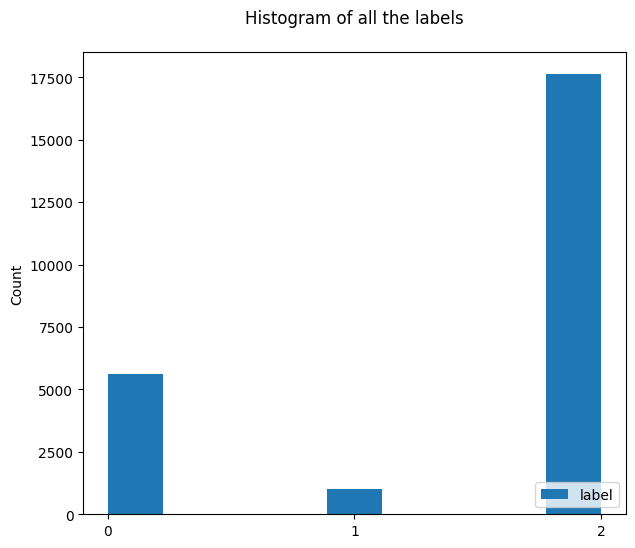

In [6]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of all the labels\n')
plt.hist([df["label"]], bins, label=['label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['label'],test_size=0.33,random_state=42)
val_text, test_text, val_labels, test_labels = train_test_split(X_test, y_test,random_state=42,test_size=0.5)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of val_text:", val_text.shape)
print("Shape of test_text:", test_text.shape)
print("Shape of val_labels:", val_labels.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of X_train: (16242,)
Shape of y_train: (16242,)
Shape of val_text: (4000,)
Shape of test_text: (4000,)
Shape of val_labels: (4000,)
Shape of test_labels: (4000,)


In [8]:
train_text = list(X_train)
train_labels = list(y_train)

test_text = list(test_text)
test_labels = list(test_labels)

val_text = list(val_text)
val_labels = list(val_labels)

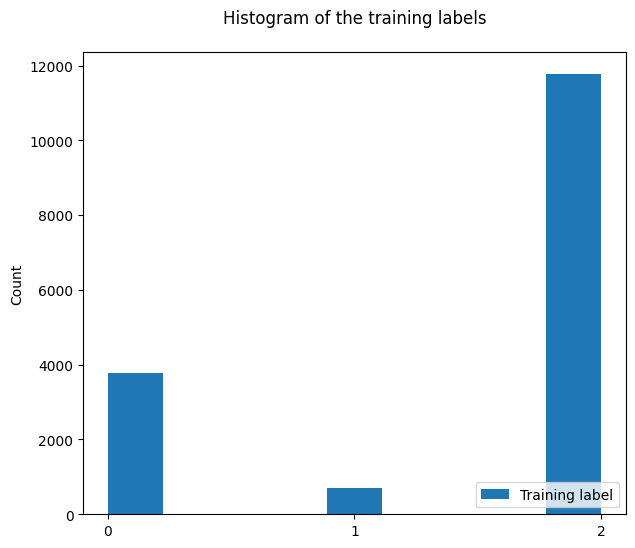

In [9]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of the training labels\n')
plt.hist([train_labels], bins, label=['Training label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
def train(dataloader, optimizer_, scheduler_, device_):

  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits
    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    scheduler.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):

  global model

  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits.
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [12]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config,ignore_mismatched_sizes=True)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading model configuraiton...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

Loading model tokenizer...


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/489k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/723k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading the model...


pytorch_model.bin:   0%|          | 0.00/267M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dexhrestha/Nepali-DistilBERT and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [13]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

train_dataset = MyDataset(train_encodings, train_labels)
valid_dataset = MyDataset(valid_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

In [14]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 2031 batches!
Created `test_dataloader` with 500 batches!
Created `valid_dataloader` with 500 batches!


In [15]:
optimizer = AdamW (model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer,
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Define variables for early stopping and model saving
early_stopping_counter = 0
early_stopping_criteria = 3  # Stop if validation loss doesn't decrease for 3 consecutive epochs
best_val_loss = float('inf')
best_model_path = "/content/drive/MyDrive/NEPAL/ML models/weights/distilbert_best_model.pt"
# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
    print()

    print('Training on batches...')
    # Perform one full pass over the training set
    train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score (train_labels, train_predict)

    # Get prediction from model on validation data
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
    val_acc = accuracy_score (valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss values for plotting the learning curve
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)

    # Store the accuracy values
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the model with the lowest validation loss
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_criteria:
        print(f'Validation loss has not decreased for {early_stopping_criteria} consecutive epochs. Early stopping...')
        break

Epoch


  0%|          | 0/20 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/2031 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/500 [00:00<?, ?it/s]

  train_loss: 0.33895 - val_loss: 0.27627 - train_acc: 0.89398 - valid_acc: 0.92350


Training on batches...


  0%|          | 0/2031 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/500 [00:00<?, ?it/s]

  train_loss: 0.20303 - val_loss: 0.33094 - train_acc: 0.95025 - valid_acc: 0.93325


Training on batches...


  0%|          | 0/2031 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/500 [00:00<?, ?it/s]

  train_loss: 0.11919 - val_loss: 0.35839 - train_acc: 0.97285 - valid_acc: 0.93575


Training on batches...


  0%|          | 0/2031 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/500 [00:00<?, ?it/s]

  train_loss: 0.07847 - val_loss: 0.40719 - train_acc: 0.98331 - valid_acc: 0.93350

Validation loss has not decreased for 3 consecutive epochs. Early stopping...


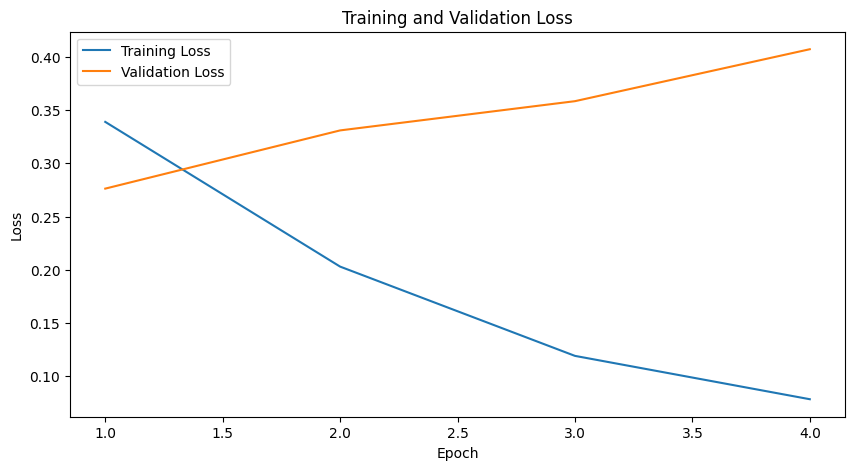

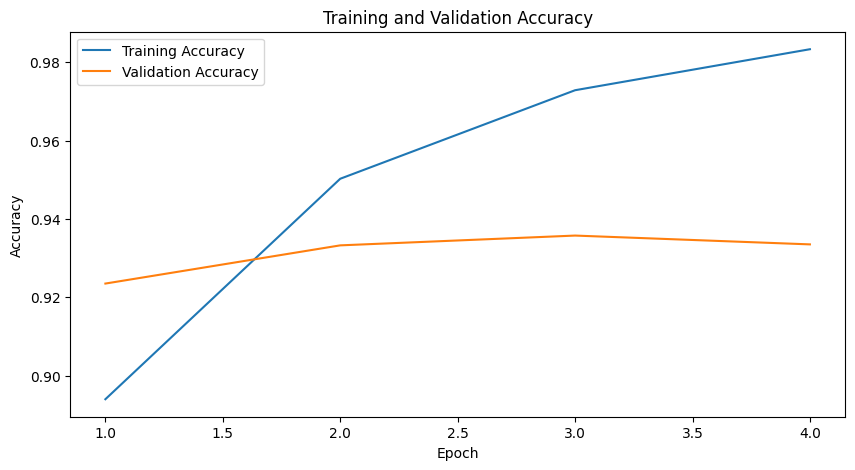

In [16]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(all_loss['train_loss']) + 1), all_loss['train_loss'], label='Training Loss')
plt.plot(range(1, len(all_loss['val_loss']) + 1), all_loss['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(all_acc['train_acc']) + 1), all_acc['train_acc'], label='Training Accuracy')
plt.plot(range(1, len(all_acc['val_acc']) + 1), all_acc['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       926
           1       0.77      0.66      0.71       164
           2       0.96      0.97      0.96      2910

    accuracy                           0.94      4000
   macro avg       0.87      0.84      0.86      4000
weighted avg       0.94      0.94      0.94      4000



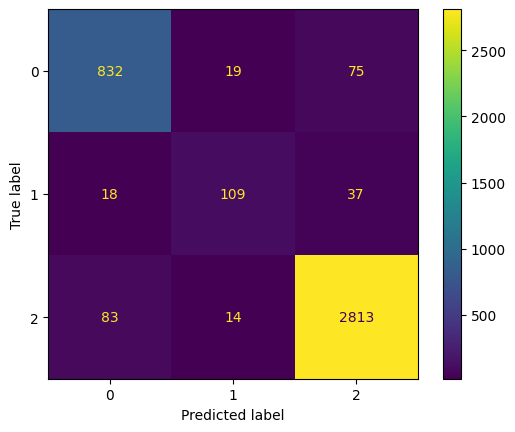

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get model predictions on the test data
true_labels, predictions_labels, avg_epoch_loss = validation (test_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report (true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Print the evaluation report
print(evaluation_report)

# Plot confusion matrix
# plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
#                       classes=list(labels_ids.keys()), normalize=True,
#                       magnify=0.1,
#                       use_title='Normalized confusion matrix'
#                       );

cm = confusion_matrix(true_labels, predictions_labels, labels=list(labels_ids.values()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(labels_ids.keys()))
disp.plot()
plt.show()

In [18]:
labels_ids.keys()

dict_keys(['0', '1', '2'])

In [19]:
from imblearn.metrics import macro_averaged_mean_absolute_error
macro_averaged_mean_absolute_error(predictions_labels, true_labels)

0.16451309352989532

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.metrics import macro_averaged_mean_absolute_error

print("Accuracy -> ",accuracy_score(predictions_labels, true_labels))
print("Recall -> ",recall_score(predictions_labels, true_labels,average='macro'))
print("Precision -> ",precision_score(predictions_labels, true_labels,average='macro'))
print("F1 score -> ",f1_score(predictions_labels, true_labels,average='macro'))
# print("MAE -> ",mean_absolute_error(predictions_labels, true_labels))
print("Macro MAE -> ",macro_averaged_mean_absolute_error(predictions_labels, true_labels))
print(confusion_matrix(predictions_labels, true_labels))

#Dist_bert sentiment

Accuracy ->  0.9385
Recall ->  0.8736873626769918
Precision ->  0.8432629779861514
F1 score ->  0.8572349527135555
Macro MAE ->  0.16451309352989532
[[ 832   18   83]
 [  19  109   14]
 [  75   37 2813]]


In [21]:
new_df = pd.DataFrame(list(zip(true_labels, predictions_labels)),
               columns =['Actual', 'dist_bert'])

In [22]:
new_df.to_csv('/content/drive/MyDrive/NEPAL/ML models/dist_bert_sentiment.csv')